In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import dateutil
from datetime import datetime
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


In [114]:
dataset = pd.read_csv('ar.csv')
print(dataset.columns.values)

['countryCode' 'customerID' 'PaperlessDate' 'invoiceNumber' 'InvoiceDate'
 'DueDate' 'InvoiceAmount' 'Disputed' 'SettledDate' 'PaperlessBill'
 'DaysToSettle' 'DaysLate']


In [115]:
#total no of invoices
totalinvoices=dataset.shape[0]
#dataset['customerID'].count()
print("Total no of invoice:",totalinvoices)

Total no of invoice: 2466


In [116]:
#No. of delayed invoices
delayed=dataset[(dataset.DaysLate>0)]
totaldelayed=delayed.shape[0]
print("No of delayed invoices:",totaldelayed)

No of delayed invoices: 877


In [117]:
percentofdelayed=(totaldelayed/totalinvoices)*100
print("percentage of delayed invoice:",percentofdelayed)

percentage of delayed invoice: 35.56366585563666


In [118]:
#No of payers in the data set
#totalpayers=len(dataset.groupby('customerID'))
#print(dataset['customerID'].value_counts())
totalpayers=(dataset['customerID'].nunique())
print("Total no of payers:",totalpayers)

Total no of payers: 100


In [119]:
# max delayed days
print("max delayed days:",dataset['DaysLate'].max())

max delayed days: 45


In [120]:
#No of invoice per payer
grouped=dataset.groupby('customerID',as_index=False)
invoice_count=grouped.agg({"invoiceNumber":"count"})
invoice_count.columns=['customerID','total']
invoice_count_sort=invoice_count.sort_values('customerID')
print(invoice_count.shape)
print(invoice_count.columns.values)
print(invoice_count_sort.head(5))

#my.plot()
#plt.show()

(100, 2)
['customerID' 'total']
   customerID  total
0  0187-ERLSR     16
1  0379-NEVHP     27
2  0465-DTULQ     26
3  0625-TNJFG     28
4  0688-XNJRO     34


In [121]:
# delayed invoices per payer
delayed=delayed.groupby('customerID',as_index=False)
delayed_invoice_count=delayed.agg({'invoiceNumber':'count'})
#right = pd.DataFrame(mydelay)
delayed_invoice_count.columns=['customerID','delayed']

print(delayed_invoice_count.shape)
delayed_invoice_count_sort=delayed_invoice_count.sort_values('customerID')
print(delayed_invoice_count.columns.values)
print(delayed_invoice_count_sort.head(5))
#mydelay.plot()
#plt.show()

(83, 2)
['customerID' 'delayed']
   customerID  delayed
0  0379-NEVHP        1
1  0465-DTULQ       14
2  0625-TNJFG        5
3  0688-XNJRO       32
4  0706-NRGUP       10


In [122]:
delayed_days_avg=delayed.agg({'DaysLate':'mean'})
delayed_days_avg.columns=['customerID','avgDaysDelayed']
print(delayed_days_avg.head(5))


   customerID  avgDaysDelayed
0  0379-NEVHP       17.000000
1  0465-DTULQ        9.857143
2  0625-TNJFG        4.000000
3  0688-XNJRO       15.343750
4  0706-NRGUP        6.900000


In [123]:
settled_days_avg=grouped.agg({'DaysToSettle':'mean'})
settled_days_avg.columns=['customerID','avgDaysToSettle']
print(settled_days_avg.head(5))

   customerID  avgDaysToSettle
0  0187-ERLSR        12.937500
1  0379-NEVHP        17.444444
2  0465-DTULQ        33.730769
3  0625-TNJFG        24.750000
4  0688-XNJRO        44.382353


In [124]:
# delay ratio per payer
invoice_count_stats=pd.merge(invoice_count,delayed_invoice_count,on='customerID',how='left').fillna(0)
invoice_count_stats=invoice_count_stats.sort_values('customerID')
invoice_count_stats['paid']=invoice_count_stats['total']-invoice_count_stats['delayed']
invoice_count_stats['delayRatio']=(invoice_count_stats['delayed']/invoice_count_stats['total'])
print(invoice_count_stats.head(10))

   customerID  total  delayed  paid  delayRatio
0  0187-ERLSR     16      0.0  16.0    0.000000
1  0379-NEVHP     27      1.0  26.0    0.037037
2  0465-DTULQ     26     14.0  12.0    0.538462
3  0625-TNJFG     28      5.0  23.0    0.178571
4  0688-XNJRO     34     32.0   2.0    0.941176
5  0706-NRGUP     18     10.0   8.0    0.555556
6  0709-LZRJV     25     11.0  14.0    0.440000
7  0783-PEPYR     21     20.0   1.0    0.952381
8  1080-NDGAE     31     18.0  13.0    0.580645
9  1168-BEASA     23      2.0  21.0    0.086957


In [125]:
# total paid invoice amount per payer
paid_tot=grouped.agg({"InvoiceAmount":"sum"})
print(paid_tot.columns.values)
paid_tot.columns=['customerID','totalAmt']
print(paid_tot.head(5))

['customerID' 'InvoiceAmount']
   customerID  totalAmt
0  0187-ERLSR   1072.63
1  0379-NEVHP   1584.18
2  0465-DTULQ   1360.12
3  0625-TNJFG   1627.26
4  0688-XNJRO   1231.45


In [126]:
# total delayed invoice amount per payer
delayed_tot=delayed.agg({"InvoiceAmount":"sum"})
delayed_tot.columns=['customerID','delayedAmt']
print(delayed_tot.head(5))

   customerID  delayedAmt
0  0379-NEVHP       48.65
1  0465-DTULQ      670.39
2  0625-TNJFG      301.94
3  0688-XNJRO     1181.00
4  0706-NRGUP      325.42


In [127]:
invoice_amt_stats=pd.merge(paid_tot,delayed_tot,on='customerID',how='left').fillna(0)
invoice_amt_stats['paidAmt']=invoice_amt_stats['totalAmt']-invoice_amt_stats['delayedAmt']
invoice_amt_stats['delayAmtRatio']=(invoice_amt_stats['delayedAmt']/invoice_amt_stats['totalAmt'])
print(invoice_amt_stats.head(5))

   customerID  totalAmt  delayedAmt  paidAmt  delayAmtRatio
0  0187-ERLSR   1072.63        0.00  1072.63       0.000000
1  0379-NEVHP   1584.18       48.65  1535.53       0.030710
2  0465-DTULQ   1360.12      670.39   689.73       0.492890
3  0625-TNJFG   1627.26      301.94  1325.32       0.185551
4  0688-XNJRO   1231.45     1181.00    50.45       0.959032


In [128]:
payer_stats=pd.merge(invoice_count_stats,invoice_amt_stats,on="customerID",how='left')
payer_stats=pd.merge(payer_stats,delayed_days_avg,on="customerID",how="left").fillna(0)
payer_stats=pd.merge(payer_stats,settled_days_avg,on="customerID",how="left").fillna(0)

print(payer_stats.head(2))


   customerID  total  delayed  paid  delayRatio  totalAmt  delayedAmt  \
0  0187-ERLSR     16      0.0  16.0    0.000000   1072.63        0.00   
1  0379-NEVHP     27      1.0  26.0    0.037037   1584.18       48.65   

   paidAmt  delayAmtRatio  avgDaysDelayed  avgDaysToSettle  
0  1072.63        0.00000             0.0        12.937500  
1  1535.53        0.03071            17.0        17.444444  


In [129]:

dataset['invoicemonth']=pd.to_datetime(dataset['InvoiceDate']).dt.month
dataset['invoicedate']=pd.to_datetime(dataset['InvoiceDate']).dt.day
dataset['invoiceday']=pd.to_datetime(dataset['InvoiceDate']).dt.weekday
dataset['monthend']=np.where(dataset['invoicedate']>27,1,0)
dataset['firsthalfmonth']=np.where(dataset['invoicedate']<16,1,0)
paperless={'Paper':0,'Electronic':1}
dataset['paperless']=dataset['PaperlessBill'].map(paperless)

#print(dt.year, dt.month, dt.day)
print(dataset.head(1))



   countryCode  customerID PaperlessDate  invoiceNumber InvoiceDate   DueDate  \
0          391  0379-NEVHP      4/6/2013         611365    1/2/2013  2/1/2013   

   InvoiceAmount Disputed SettledDate PaperlessBill  DaysToSettle  DaysLate  \
0          55.94       No   1/15/2013         Paper            13         0   

   invoicemonth  invoicedate  invoiceday  monthend  firsthalfmonth  paperless  
0             1            2           2         0               1          0  


In [160]:
#dataset.columns.values[1]='payer'
#dataset_new=dataset.join(payer_stats.set_index('payer'))
dataset_new=pd.merge(dataset,payer_stats,on='customerID',how='left').fillna(0)
custlist=payer_stats['customerID'].tolist()
cat = {x: custlist.index(x) for x in custlist}
dataset_new['cust']= dataset_new['customerID'].map(cat)

## features used for training
dataset_new=dataset_new[['cust','InvoiceAmount','invoicemonth','monthend','firsthalfmonth','paperless','avgDaysToSettle','DaysToSettle']]
                         #'total','totalAmt','avgDaysToSettle','DaysToSettle']]
                            # 'avgDaysToSettle'
print(dataset_new.columns.values)
#print(dataset_new.shape)
#dummies = pd.get_dummies(dataset_new.customerID)
print(dataset_new.head(2))




['InvoiceAmount' 'invoicemonth' 'monthend' 'firsthalfmonth' 'paperless'
 'avgDaysToSettle' 'DaysToSettle']
   InvoiceAmount  invoicemonth  monthend  firsthalfmonth  paperless  \
0          55.94             1         0               1          0   
1          61.74             1         0               0          1   

   avgDaysToSettle  DaysToSettle  
0        17.444444            13  
1        25.777778            36  


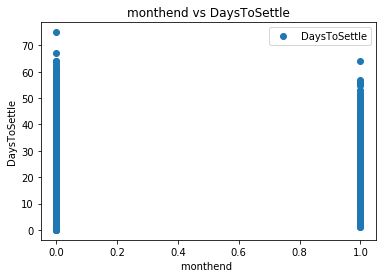

In [161]:
dataset.plot(x='monthend', y='DaysToSettle', style='o')  
plt.title('monthend vs DaysToSettle')  
plt.xlabel('monthend ')  
plt.ylabel('DaysToSettle')  
plt.show() 

In [162]:
cols=dataset_new.columns
dataset_new[cols] = dataset_new[cols].apply(pd.to_numeric)
print(dataset_new.dtypes)

InvoiceAmount      float64
invoicemonth         int64
monthend             int64
firsthalfmonth       int64
paperless            int64
avgDaysToSettle    float64
DaysToSettle         int64
dtype: object


In [163]:
array=dataset_new.values
n=len(dataset_new.columns)
X=array[:,0:n-1]
Y=array[:,n-1]
seed=7
X_train, X_rest, Y_train, Y_rest = model_selection.train_test_split(X,Y,test_size=0.40,random_state=seed)
X_validation,X_test,Y_validation,Y_test=model_selection.train_test_split(X_rest,Y_rest,test_size=0.50,random_state=seed)

In [164]:
# np.argwhere(np.isinf(X_train))


In [165]:
lm=LinearRegression()
#lm.fit(X_train,Y_train)

In [166]:
#predict_train=lm.predict(X_train)
#predict_val=lm.predict(X_validation)
rfe = RFE(lm, 4)
fit = rfe.fit(X_train, Y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 4
Selected Features: [False False  True  True  True  True]
Feature Ranking: [3 2 1 1 1 1]


In [167]:
lm.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [168]:
# %  of changes in Y that can be  explained using X
lm.score(X_validation, Y_validation)

0.6784911702895905

In [169]:
lm.score(X_train, Y_train)

0.6761413886250978

In [170]:
from sklearn.metrics import mean_squared_error

y_predict = lm.predict(X_validation)

regression_model_mse = mean_squared_error(y_predict, Y_validation)

regression_model_mse

48.61297794984481

In [171]:
import math

math.sqrt(regression_model_mse)

6.972300764442453

In [106]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(lm, open(filename, 'wb'))

In [107]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.6532099296210785
